In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
# Dataset Paths
train_data_dir = "/kaggle/input/iris-data/Retinal fundus images for DR/1.train"
val_data_dir = "/kaggle/input/iris-data/Retinal fundus images for DR/2.val"

# Image Preprocessing and Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Training Data Generator
train_generator = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Validation Data Generator
val_generator = val_datagen.flow_from_directory(
    directory=val_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Categories and Class Count
categories = [
    "1._No_DR_signs", "2.Mild(or_early)_NPDR", "3._Moderate_NPDR",
    "4._Severe_NPDR", "5._Very_Severe_NPDR", "6._PDR", "7._Advanced_PDR"
]
num_classes = len(categories)



Found 638 images belonging to 7 classes.
Found 136 images belonging to 7 classes.


In [3]:
# Load Pretrained DenseNet Model
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in densenet_base.layers:
    layer.trainable = False  # Freeze base model layers

# Custom Classification Head
x = GlobalAveragePooling2D()(densenet_base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=densenet_base.input, outputs=output_layer)

model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,565,895 (28.86 MB)

 Trainable params: 528,391 (2.02 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [4]:
# Compile Model
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
epochs = 10
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    verbose=1
)

# Evaluate Model
y_true = []
y_pred = []
for images, labels in val_generator:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels, axis=1))
    if len(y_true) >= val_generator.samples:
        break
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=categories))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.1792 - loss: 2.3587 - val_accuracy: 0.3382 - val_loss: 1.7038
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3141 - loss: 1.8319 - val_accuracy: 0.4338 - val_loss: 1.5354
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3889 - loss: 1.7242 - val_accuracy: 0.4632 - val_loss: 1.4689
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4114 - loss: 1.5468 - val_accuracy: 0.5000 - val_loss: 1.3794
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.4946 - loss: 1.4040 - val_accuracy: 0.5588 - val_loss: 1.3201
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4989 - loss: 1.3785 - val_accuracy: 0.5368 - val_loss: 1.2842
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5202 - loss: 1.2943 - val_accuracy: 0.5588 - val_loss: 1.2526
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5449 - loss: 1.2301 - val_accuracy: 0.5956 - val_loss: 1.1955
Epo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


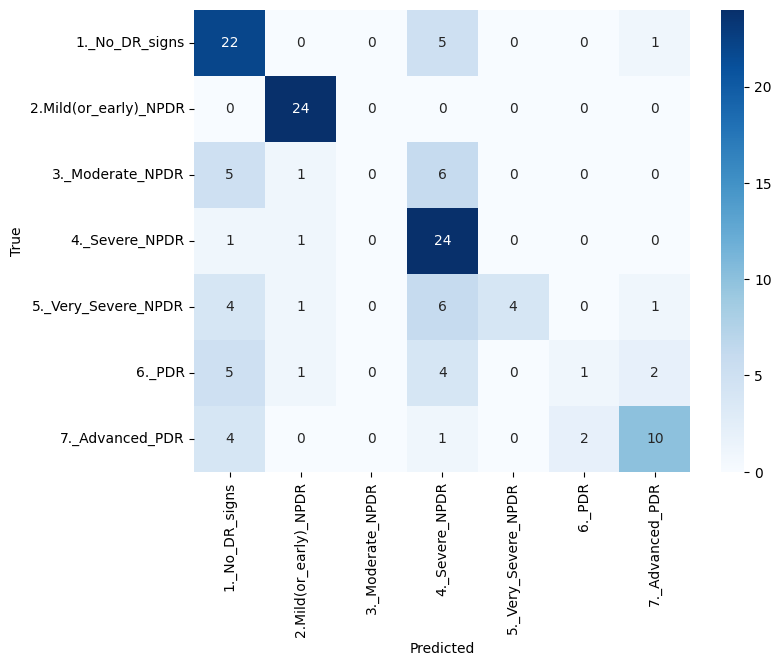

In [5]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Custom Metrics Calculation
def calculate_metrics(cm):
    TN = np.diag(cm).sum() - np.diag(cm)
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    
    precision = TP / (TP + FP + 1e-7)
    recall = TP / (TP + FN + 1e-7)
    specificity = TN / (TN + FP + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
    
    return {
        "Precision": np.mean(precision),
        "Recall (Sensitivity)": np.mean(recall),
        "Specificity": np.mean(specificity),
        "F1 Score": np.mean(f1_score)
    }


In [6]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, in_channels):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x